# <center>**Projeto de Disciplina de Validação de modelos de clusterização [24E4_3]**</center>
# <center>**Aluna: Rachel Reuters**</center>

## PARTE 1- INFRAESTRUTURA

In [6]:
import platform
import sys

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Architecture:", platform.architecture())
print("Processor:", platform.processor())
print("System:", platform.system())
print("Machine:", platform.machine())
print("Release:", platform.release())
print("Node:", platform.node())

Python version: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.22621-SP0
Architecture: ('64bit', 'WindowsPE')
Processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
System: Windows
Machine: AMD64
Release: 10
Node: DESKTOP-4U6C9N4


In [5]:
import subprocess

def get_conda_info():
    result = subprocess.run(['conda', 'info'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

print("Conda Info:")
get_conda_info()


Conda Info:

     active environment : py39
    active env location : C:\Users\belch\anaconda3\envs\py39
            shell level : 1
       user config file : C:\Users\belch\.condarc
 populated config files : C:\Users\belch\.condarc
          conda version : 24.5.0
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.5.0=0
                          __cuda=12.6=0
                          __win=0=0
       base environment : C:\Users\belch\anaconda3  (writable)
      conda av data dir : C:\Users\belch\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                        

In [7]:

with open('requirements.txt', 'r') as file:
    requirements = file.read()

print(requirements)

matplotlib==3.9.2
numpy==1.26.4
pandas==2.2.1
scikit-learn==1.5.2
scipy==1.13.1
seaborn==0.13.2
scikit-learn-extra==0.3.0
data_science_utils==1.8.0


## PARTE 2 - ESCOLHA DA BASE DE DADOS

Numero de Musicas do dataset:  20594
Tipos de dados:
Artist               object
Track                object
Album                object
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
Duration_min        float64
Title                object
Views               float64
Likes               float64
Comments            float64
EnergyLiveness      float64
dtype: object
Quantidade de colunas para analise:
14
Dados faltantes:
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_min        0
Views               0
Likes               0
Comments            0
EnergyLiveness      2
dtype: int64
Novo Numero de Musicas do dataset:  20592


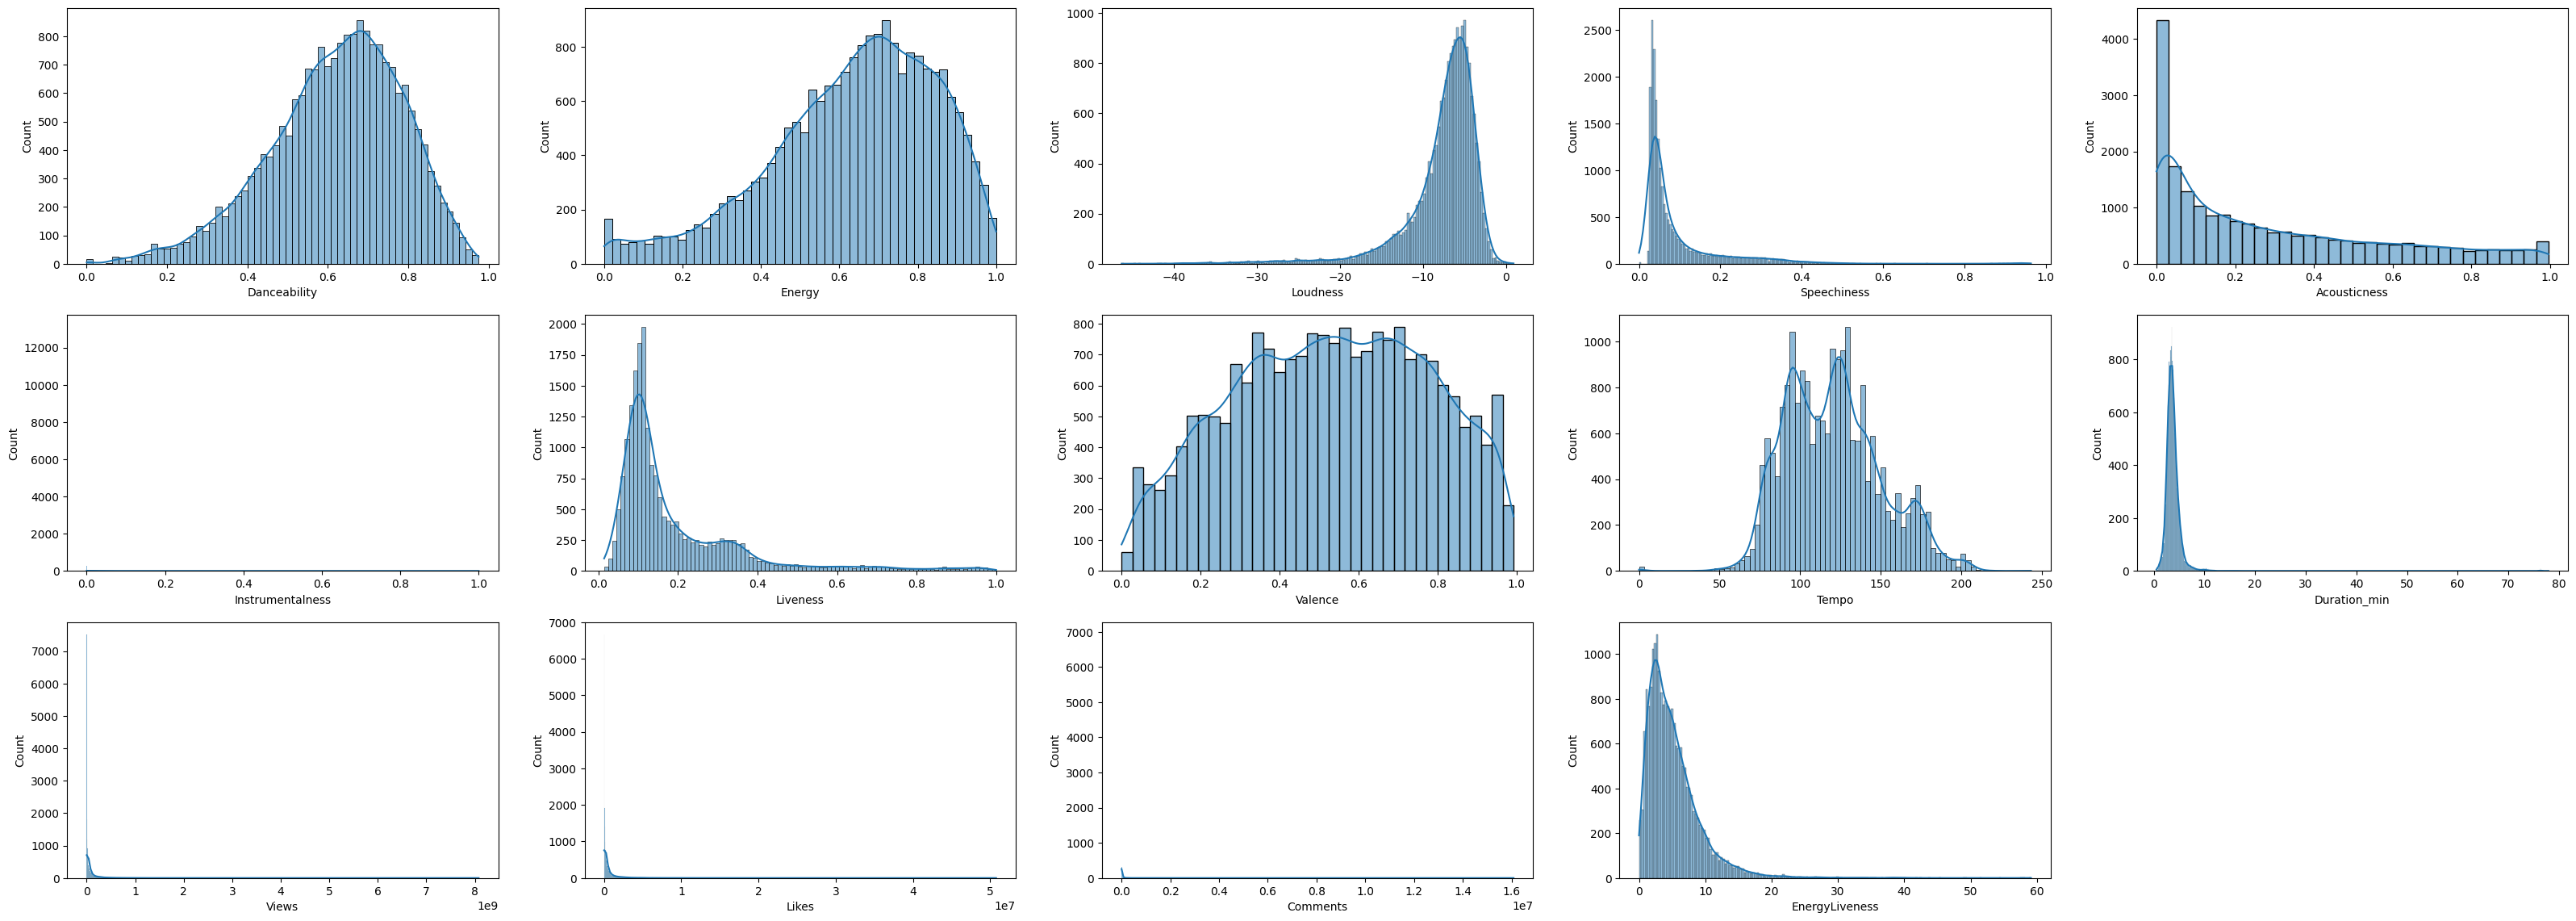

In [1]:
#1. Escolha uma base de dados para realizar o trabalho. Essa base será usada em um problema de clusterização.
# Escolhi utilizar o dataset do Spotify https://www.kaggle.com/datasets/sanjanchaudhari/spotify-dataset?select=cleaned_dataset.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt 
import seaborn as sns

dataset_original = pd.read_csv('cleaned_dataset.csv', sep=',', decimal='.')

print("Numero de Musicas do dataset: ", dataset_original.shape[0])


#2. Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos.
# Gostaria de fazer um sistema de recomendacao de musicas. Onde eu possa colocar uma musica de exemplo 
# e gostaria que o programa me falasse quais musicas sao parecidas.

#3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. 
# Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

#Irei remover algumas colunas que nao sao relevantes para a analise sendo feita
dataset_original.drop(['Licensed','official_video','Stream', 'most_playedon', 'Channel', 'Album_type' ] , axis=1, inplace=True)

print("Tipos de dados:")
print(dataset_original.dtypes)


#Para a analise vamos utilizar apenas os dados numericos :

dataset_numerico = dataset_original.drop(['Artist', 'Track', 'Album', 'Title' ], axis=1)


print("Quantidade de colunas para analise:")
print(dataset_numerico.shape[1])


#Verificar se tem nulos
print("Dados faltantes:")
print(dataset_numerico.isna().sum())

#Como sao apenas 2 linhas e nao acredito que colocar um valor sem saber a origem correta seria a melhor opcao, irei remover esses dois itens
dataset_original = dataset_original.dropna(subset=['EnergyLiveness'])
dataset_numerico = dataset_numerico.dropna(subset=['EnergyLiveness'])
                       


print("Novo Numero de Musicas do dataset: ", dataset_original.shape[0])

plt.figure(figsize=(40, 14))

for index, value in enumerate(dataset_numerico.columns):
    plt.subplot(3, 5,index+1)
    sns.histplot(dataset_numerico[value], kde=True)





In [ ]:
#4. Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

# Podemos observar que a coluna de comentario pode nao refletir muita informacao para diferenciar as musicas, podendo ser
# comentario positivo ou negativo. 

dataset_numerico = dataset_numerico.drop(['Comments'], axis=1)

Dados faltantes:
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_min        0
Views               0
Likes               0
Comments            0
EnergyLiveness      0
dtype: int64


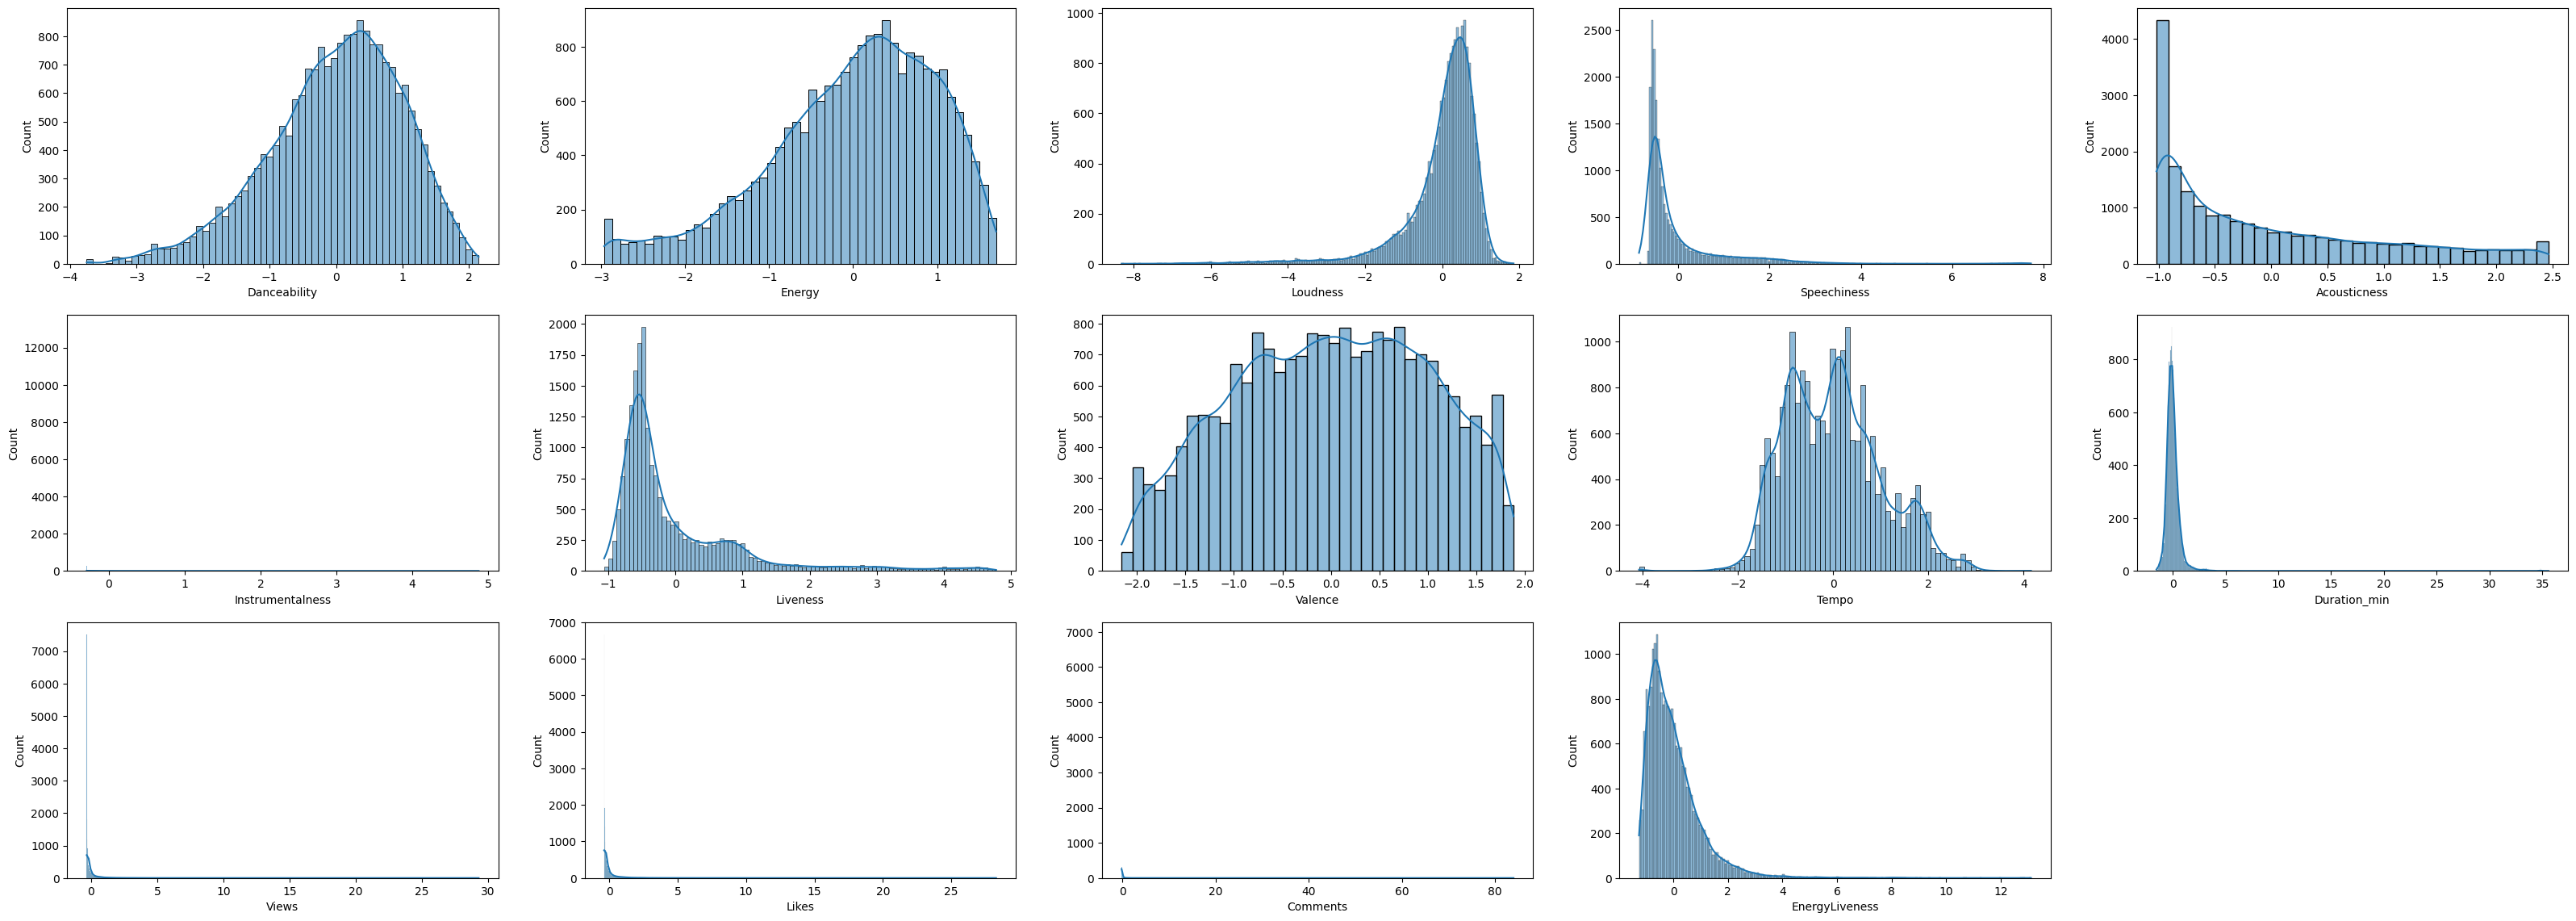

In [2]:

#Alem disso podemos verificar que os dados estao com escalas diferentes. Precisamos aplicar uma normalizacao. 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataset_numerico)
dataset_normalizado = scaler.transform(dataset_numerico)

dataset_normalizado  = pd.DataFrame(dataset_normalizado)

plt.figure(figsize=(40, 14))

for index, value in enumerate(dataset_normalizado.columns):
    plt.subplot(3, 5,index+1)
    sns.histplot(dataset_normalizado[value], kde=True)
    plt.xlabel(dataset_numerico.columns[index])


# PARTE 3 - CLUSTERIZAÇÃO